In [1]:
%load_ext autoreload
%autoreload 2
%aimport
import statistics
from math import lgamma
from src.bayesian import *
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from scipy.stats import beta
from tqdm.notebook import tqdm
from p_tqdm import p_map
print("Ссылка на описание байесовского AB-тестирования для базы знаний, \n")
print("https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit")

Modules to reload:
all-except-skipped

Modules to skip:

Ссылка на описание байесовского AB-тестирования для базы знаний, 

https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit


# Описание работы Байесовских алгоритмов



## Отличия байесовского подхода от классического

## Принцип работы
Предполагается некое априорное распределения метрик (биномиальные, нормальное,
экспоненциальное и т.д.). Затем, используя полученные данные (новую информацию), мы
пересчитываем распределения для метрик. При помощи распределения

## Основные критерии принятия решений

Основная проблема Байесовских тестов по сравнению с классическими - проблема
контроля ошибки 1 и 2 рода. Особенно это проявляется в случае ранней остановки
алгоритма (когда мы заканчиваем эксперимент при достижении определенных значений
критериев). Ниже будут описаны основные критерии принятия решений
в случае байесовских тестов
(как для алгоритма Томпсона, так и для разбивки 50 на 50).

### Вероятность превосходства для конверсии
Английские термины: *chance to beat control*, *probability superiority*

В случае алгоритма на конверсию у нас в качестве априорного распределения берется
биномиальное. Для того чтобы пересчитать апостериорную вероятность для биномиального
распределения, используется сопряженное ему бета-распределение.
Вероятность превосходства  можно посчитать двумя способами: по точной формуле или при помощи генерации
случайных величин из бета-распределения с параметрами на момент пересчета.

Точная формула описана [здесь](https://www.johndcook.com/UTMDABTR-005-05.pdf).

Метод сэмплирования следующий:

1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Смотрим сумму положительных значений для теста
4. Суммируем и делим на число сэмплирований

In [2]:
# Посмотрим на результаты, полученные разными способами
alphas, betas = [10, 20], [100, 200]
print(f"Точная формула: {calc_prob_between(alphas, betas)}")
print(f"Сэмплирование: {chance_to_beat_all(np.array(alphas), np.array(betas))}")

Точная формула: 0.5148327134707491
Сэмплирование: [0.485663 0.514681]


Отметим, что сэмплирование приводит примерно к тому же результату, но при большом
количестве генераций случайных распределений (например, 1 млн).

Важный момент, который важно понять - эта вероятность превосходства
верна только для текущего набора наблюдений. Другими словами,
мы не знаем, как все изменится при добавлении других данных.
А вот как раз в случае p-value мы можем предположить, в скольких
случаях выигрышный на данный момент вариант может на самом
деле оказаться проигрышным в будущем.

Экспериментальным путем однако выявлено, что в случае
Байесовских тестов без остановки для контроля ошибок
1,2 рода, вероятности превосходства вполне достаточно.

### Ожидаемые потери
Английский термин: *expected losses*

Данный критерий описан в [статье](https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#1)
*Chris Stucchio* - разработчика
самого лучшего инструмента для АБ-тестов
*Visual Website Optimizer*.


Ожидаемые потери контрольного / тестового варианта - сколько мы ожидаем в среднем потерь в случае,
если выберем контрольный / тестовый вариант. Считается похожим
образом, как и сэплированная вероятность превосходства:
1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Отрицательной разнице присваиваем 0
4. Суммируем и делим на число сэмплирований

Определяем некий порог и в бой!

### Размер эффекта
Английский термин: *effect size*

Размер эффект дополняет показатель разницы конверсий и
рассчитывается по такой формуле:

$
\frac{\hat{p_1} - \hat{p_2}} {
[\hat{p_1} * (1 - \hat{p_1}) * (n_1 - 1) + \hat{p_2} *
(1 - \hat{p_2}) * (n_2 - 1)] /
(n_1 + n_2 - 2)}
$

### Достоверные интервалы
Английский термин: *credible intervals*

Достоверные интервалы являются аналогом доверительных интервалов в случае
классических АБ-тестов. Однако, достоверные интервалы фиксируют
нашу текущую неопределенность о потенциальных значениях параметра и
могут быть интерпретированы как вероятностное утверждение о параметре.

Доверительные интервалы отражают неопределенность относительно
полученного нами интервала (т.е. содержит ли он истинное значение или нет).
Таким образом, их нельзя интерпретировать как вероятностное утверждение
об истинных значениях параметров.

Сравним интерпретацию 95% доверительного и достоверного интервала.

В случае доверительного интервала в 95% экспериментах истинное значение
параметра будет лежать в данном диапазоне.

В случае достоверного интервала 95% ВСЕХ ЗНАЧЕНИЙ лежит в этом диапазоне.

### Область практической эквивалентности
Английский термин: *ROPE - region of practical equivalence*

Данный критерий может помочь принять нулевую гипотезу - случай
отсутствия разницы между разными вариантами теста. Рекомендуемое значение
границ *ROPE* = +- 0.1 для размера эффекта.

Если *credible intervals* полностью лежат внутри ROPE, то
делаем вывод, что разницы нет.

## Пример реализации Байесовских тестов с разными критериями

Будем пользоваться пакетом abyes и собственными вычислениями
В этом пакете мы можем выбрать несколько критериев:
- decision_var = ['es' - effect size; 'lift' - разница эффектов]
- rule = ['loss', 'rope']

Возьмем конверсии с крайне маленькими значениями и существенным улучшением: 0.02 (контрольный вариант)
против 0.025 (тестовый вариант). - 25% улучшение

In [3]:
print(f"Нужно наблюдений для классического теста: {get_size_zratio(2, 25, 0.05, 0.2)}")

Нужно наблюдений для классического теста: 13806


***Критерий 1:*** ожидаемые потери при выборе контрольного варианта = 0,25%. (Чем они больше, тем выше вероятность, что тестовый вариант лучше)


*** abyes ***

Method = analytic
Decision Rule = loss
Threshold of Caring = 0.0025
Decision Variable = lift

Result is conclusive: B variant is winner!



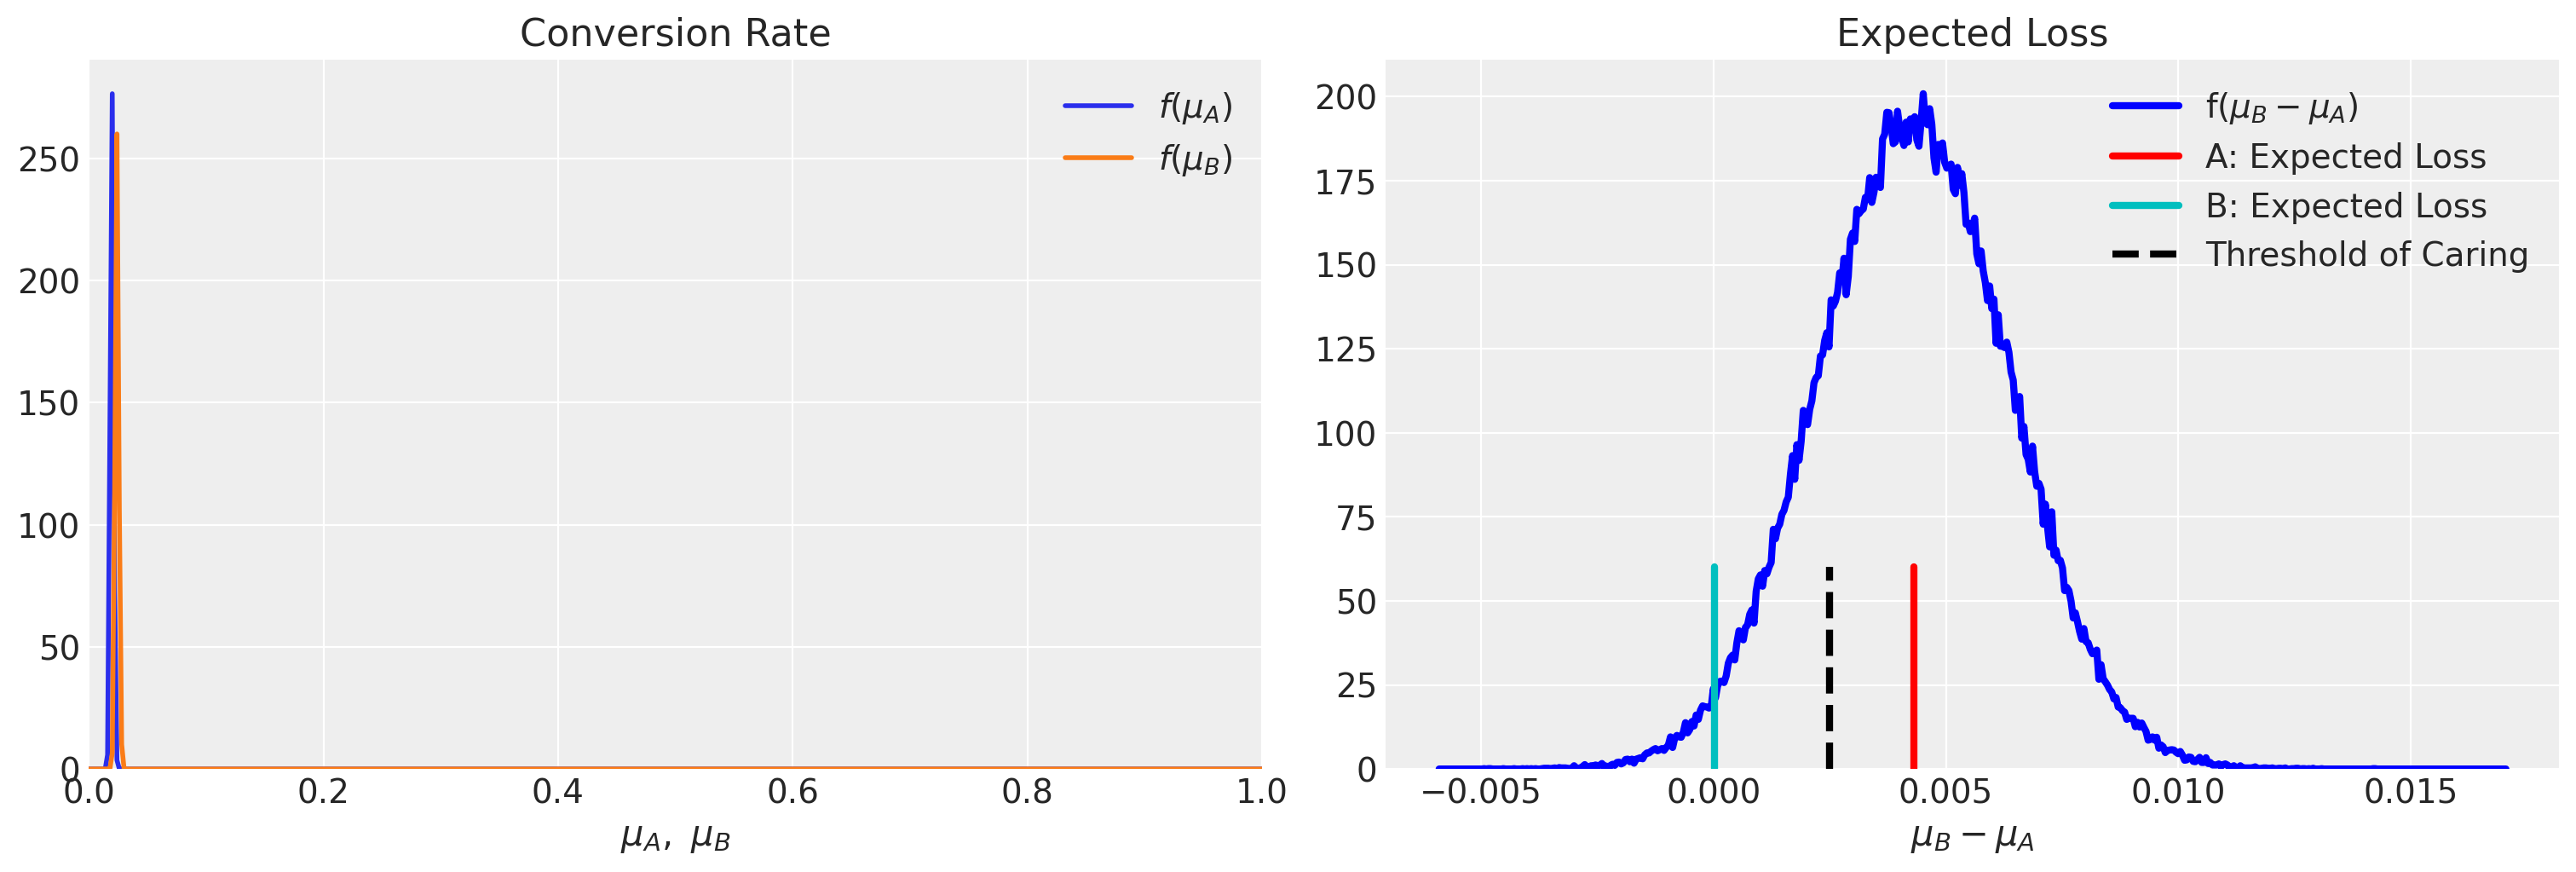

1

In [20]:
import abyes as ab
np.random.seed(0)
data = np.random.binomial([1, 1], [0.02, 0.025], size=(10000, 2))

exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='loss', toc=0.0025, alpha=0.95, plot=True)
exp.experiment(data.T)

In [5]:
print(f"Значения конверсий на текущий момент: {data.mean(axis=0)}")

Значения конверсий на текущий момент: [0.0197 0.024 ]


Попробуем ***второй критерий*** - lift + ROPE.

In [6]:
0.025 - 0.02

0.005000000000000001


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.005, 0.005)
Decision Variable = lift

Result is inconclusive.



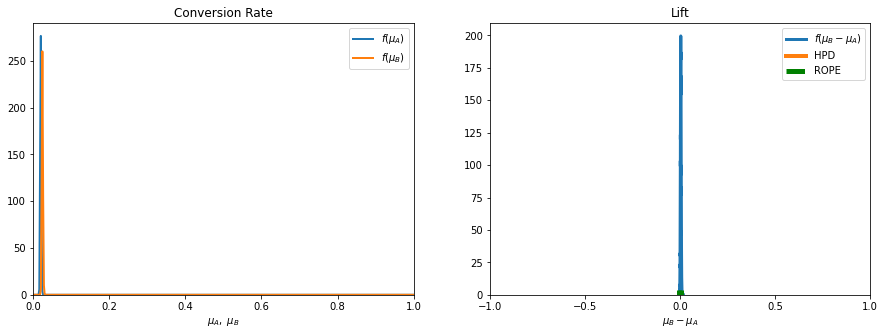

In [7]:
exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='rope', rope=(-0.005,0.005), alpha=0.95, plot=True)
results = exp.experiment(data.T)

По этому критерию у нас недостаточно данных, чтобы принять решение. Вероятно, что
мы выбрали неправильный порог для ROPE.

Попробуем ***третий критерий*** - effect size + ROPE

Вычислим теперь все показатели самостоятельно.


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.005, 0.005)
Decision Variable = es

Result is inconclusive.



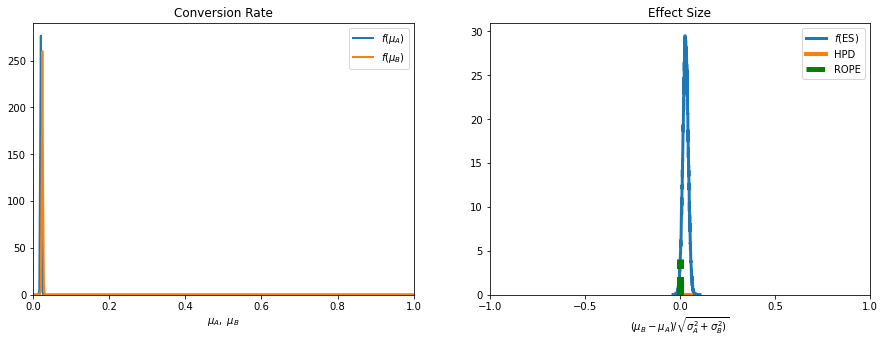

nan

In [8]:
exp = ab.AbExp(method='analytic', decision_var = 'es',
               rule='rope', rope=(-0.005,0.005), alpha=0.95, plot=True)
exp.experiment(data.T)

Вероятно и здесь мы не очень грамотно выбрали пороговые значения.

In [9]:
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
bayesian_metrics(alphas, betas)

(array([0.018369, 0.981567]),
 array([4.31431435e-03, 1.41507983e-05]),
 array([ 0.22446831, -0.17587198]),
               n1     n2     mu1    mu2      var1      var2 effect_size  \
 var1 var2                                                                
 0    1     10000  10000  0.0197  0.024  0.019312  0.023424   -0.029416   
 
                                                   HDI_lift  
 var1 var2                                                   
 0    1     [-0.008385091429339957, -0.0002835192720311297]  )

Видим, что HDI выходят за нулевое значение.


In [5]:
def get_corr_bayes_metrics(i):
    np.random.seed(i)
    data = np.random.binomial([1, 1], [0.02, 0.025], size=(10000, 2))
    alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
    results = bayesian_metrics(alphas, betas)
    prob_super_test = results[0][1]
    expected_losses_test = results[1][1]
    expected_related_losses_test = results[2][1]
    effect_size_test = results[3]['effect_size'].values[0]
    left_hdi = results[3]['HDI_lift'].values[0][0]
    right_hdi = results[3]['HDI_lift'].values[0][1]
    return (prob_super_test, expected_losses_test, expected_related_losses_test,
            effect_size_test, left_hdi, right_hdi)

results = list(p_map(get_corr_bayes_metrics, range(1000)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
print(df.corr())

                              prob_super_test  expected_losses_test  \
prob_super_test                      1.000000             -0.939829   
expected_losses_test                -0.939829              1.000000   
expected_related_losses_test        -0.765585              0.628090   
effect_size_test                    -0.728023              0.587510   
hdi_left                            -0.761103              0.624578   
hdi_right                           -0.767574              0.629642   

                              expected_related_losses_test  effect_size_test  \
prob_super_test                                  -0.765585         -0.728023   
expected_losses_test                              0.628090          0.587510   
expected_related_losses_test                      1.000000          0.996499   
effect_size_test                                  0.996499          1.000000   
hdi_left                                          0.998537          0.992576   
hdi_right             

Идентичные пары критериев:
- chance to beat control и expected loss (0.94 корреляция)
- expected related losses и effect size (0.99 корреляция)
- HDI и effect size (0.99 корреляция)
- expected related losses и HDI (0.99 корреляция)

Сравним с готовой реализацией pyMC3

In [15]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.math as pmm

from scipy.stats import bernoulli, expon

print(f"Running on PyMC3 v{pm.__version__}")

@dataclass
class BetaPrior:
    alpha: float
    beta: float
@dataclass
class BinomialData:
    trials: int
    successes: int

RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

Running on PyMC3 v3.11.4


In [42]:
def generate_binomial_data(
        variants: List[str],
        true_rates: List[float],
        samples_per_variant: int = 10000
) -> pd.DataFrame:
    data = {}
    np.random.seed(0)
    for variant, p in zip(variants, true_rates):
        data[variant] = np.random.binomial(1, p=p, size=samples_per_variant)
    agg = (
        pd.DataFrame(data)
            .aggregate(["count", "sum"])
            .rename(index={"count": "trials", "sum": "successes"})
    )
    return agg
# Example generated data
generate_binomial_data(["A", "B"], [0.02, 0.025])

,A,B
trials,10000,10000
successes,183,259


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 53 seconds.


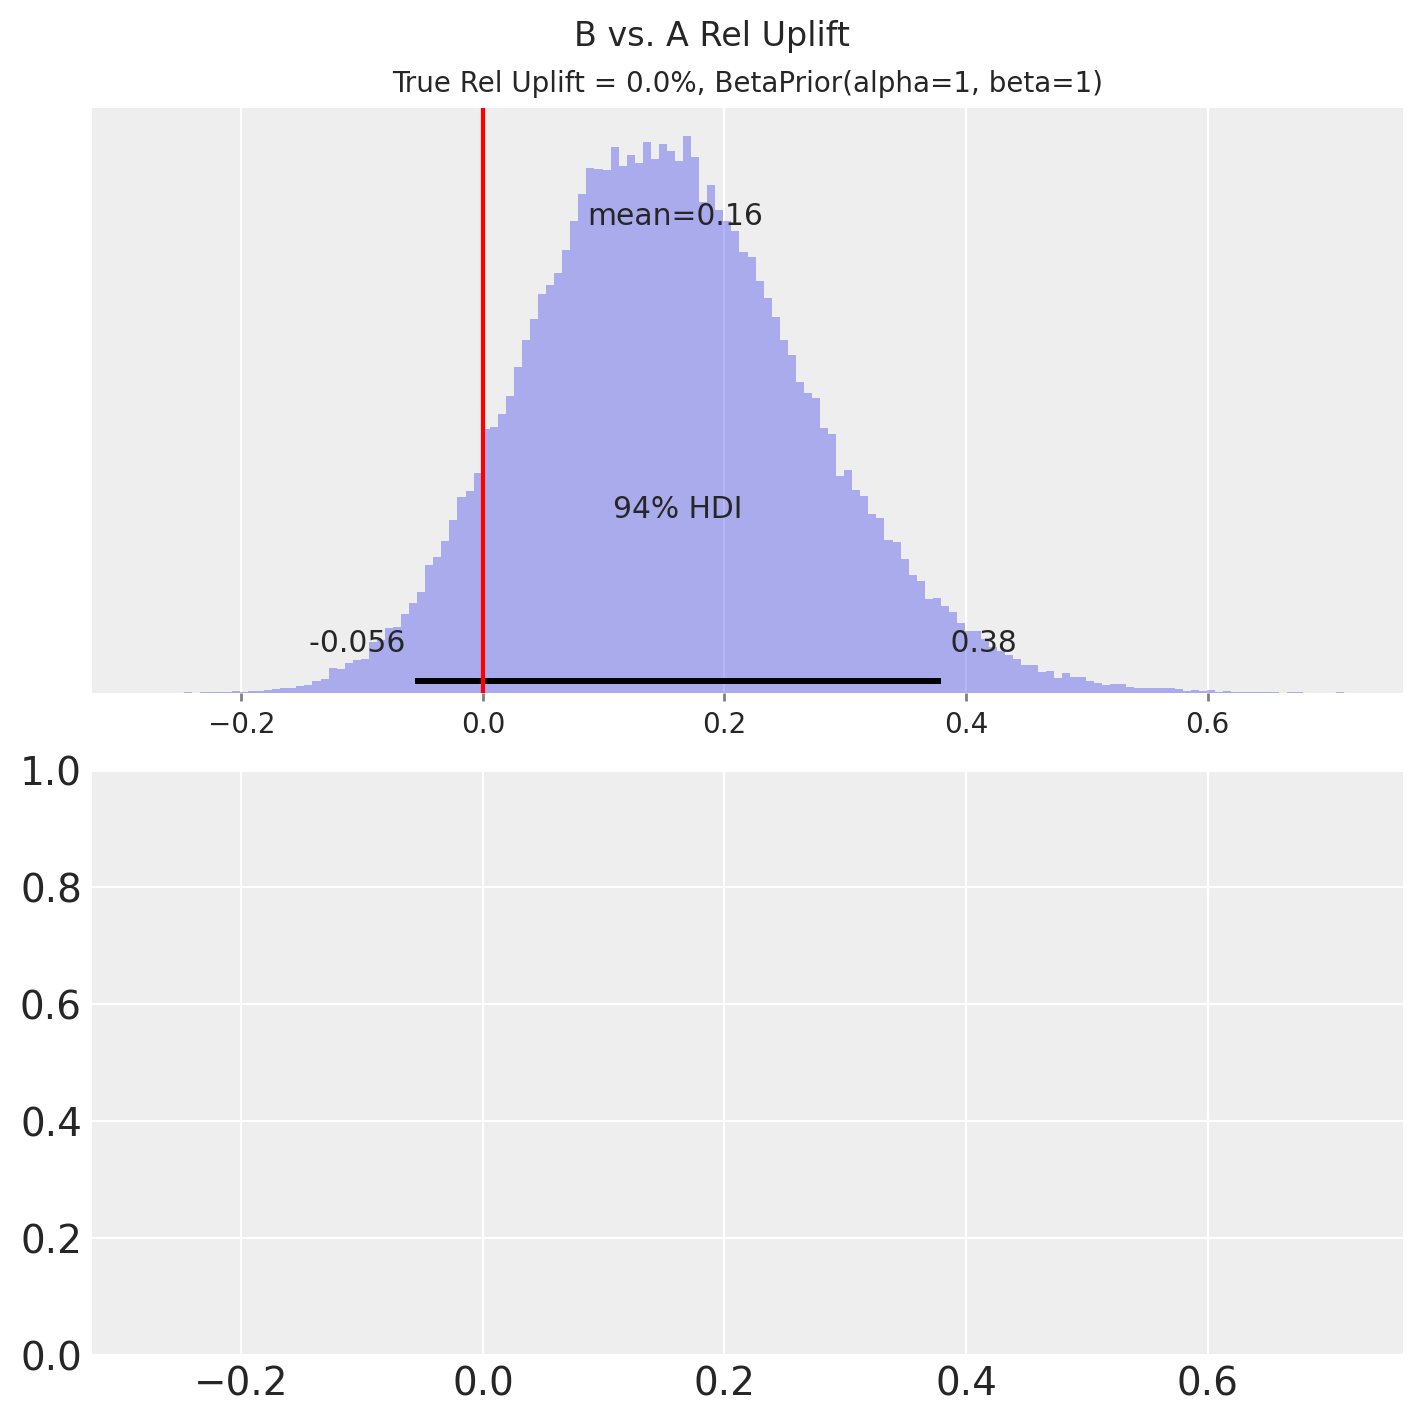

In [61]:
def run_scenario_twovariant(
        variants: List[str],
        true_rates: List[float],
        samples_per_variant: int,
        our_prior: BetaPrior
        # weak_prior: BetaPrior,
        # strong_prior: BetaPrior,
):
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModelTwoVariant(priors=our_prior).create_model(data):
        trace_our = pm.sample(draws=50000, return_inferencedata=True, cores=1, chains=2)
    # with ConversionModelTwoVariant(priors=weak_prior).create_model(data):
    #     trace_weak = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)
    # with ConversionModelTwoVariant(priors=strong_prior).create_model(data):
    #     trace_strong = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)

    true_rel_uplift = true_rates[1] / true_rates[0] - 1

    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(trace_our.posterior["reluplift_b"], textsize=10, ax=axs[0], kind="hist")
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {our_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    # az.plot_posterior(trace_strong.posterior["reluplift_b"], textsize=10, ax=axs[1], kind="hist")
    # axs[1].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}", fontsize=10)
    # axs[1].axvline(x=0, color="red")
    fig.suptitle("B vs. A Rel Uplift")
    return data
data = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.02, 0.02],
    samples_per_variant=10000,
    our_prior=BetaPrior(alpha=1, beta=1)
    # weak_prior=BetaPrior(alpha=100, beta=100),
    # strong_prior=BetaPrior(alpha=10000, beta=10000),
)

In [14]:
def get_metrics(i):
    np.random.seed(i)
    data = np.random.binomial([1, 1], [0.02, 0.025], size=(10000, 2))
    alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
    hdi_zero_belong = hdi_difference(alphas, betas)[0] < 0 < hdi_difference(alphas, betas)[1]
    ctbc = chance_to_beat_all(alphas, betas)[1]
    return (hdi_zero_belong, ctbc)
results = list(p_map(get_metrics, range(1000)))
df = pd.DataFrame(columns=['hdi_zero', 'ctbc'])
df['hdi_zero'] = [results[i][0] for i in range(1000)]
df['ctbc'] = [results[i][1] for i in range(1000)]

print(df.query("ctbc <= 0.975").shape[0])
print(df.query("hdi_zero == True").shape[0])
print(df.query("ctbc >= 0.95 & hdi_zero == False").shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

1000
291
0


In [33]:
print(df.query("ctbc <= 0.975").shape[0])
print(df.query("hdi_zero == True").shape[0])
print(df.query("ctbc >= 0.9 | hdi_zero == False").shape[0])

313
291
875


In [24]:
df.query("hdi_zero == False")

,hdi_zero,ctbc
0,False,0.981351
4,False,0.999273
6,False,0.996868
7,False,0.997042
8,False,0.978960
...,...,...
993,False,0.999366
994,False,0.997944
995,False,0.999743
996,False,0.999994


In [34]:
df.query("ctbc >= 0.9")

,hdi_zero,ctbc
0,False,0.981351
4,False,0.999273
6,False,0.996868
7,False,0.997042
8,False,0.978960
...,...,...
995,False,0.999743
996,False,0.999994
997,True,0.943766
998,False,0.991512


# CPRIOR package for conversion rates

In [22]:
from scipy import stats
from cprior.models import BernoulliModel, BernoulliMVTest, BernoulliABTest
from cprior.experiment.base import Experiment

modelA = BernoulliModel(name="control", alpha=1, beta=1)
modelB = BernoulliModel(name="variation", alpha=1, beta=1)

mvtest = BernoulliMVTest({"A": modelA, "B": modelB})

experiment = Experiment(name="CTR", test=mvtest,
                        stopping_rule="probability_vs_all",
                        epsilon=0.99, min_n_samples=1000, max_n_samples=None)

with experiment as e:
    while not e.termination:
        data_A = np.random.binomial(1, p=0.02, size=np.random.randint(100, 200))
        data_B = np.random.binomial(1, p=0.025, size=np.random.randint(100, 200))

        e.run_update(**{"A": data_A, "B": data_B})
    print(e.termination, e.status)

True winner B


In [126]:
np.random.seed(100)
modelA = BernoulliModel(alpha=1, beta=1)
modelB = BernoulliModel(alpha=1, beta=1)

test = BernoulliABTest(modelA=modelA, modelB=modelB)
test.update_A([0, 1])

test.update_B([0, 1])
batch_size = 10
p_control_percent, mde_percent = 2, 0
n_obs_every_arm = get_size_zratio(p_control_percent, mde_percent, alpha=0.05, beta=0.2)
p1, mde_test = p_control_percent / 100, -(p_control_percent * mde_percent) / 10000
p2 = p1 - mde_test
probability_superiority_step_list = []  # how share of traffic changes across experiment
observations_step_list = np.array([0, 0])  # how many observations is cumulated in every step
expected_loss_step_list = []
alphas_step_list, betas_step_list = np.array([0, 0]), np.array([0, 0])
criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
                 (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
                 (np.sum(observations_step_list) < n_obs_every_arm * 3)
while criterion_stop:
    probability_superiority_step_list.append(test.probability(variant="B"))
    data_A_size = int(batch_size * test.probability(variant="A"))
    data_B_size = int(batch_size * test.probability(variant="B"))
    data_A = np.random.binomial(n=1, p=p1, size=data_A_size)
    data_B = np.random.binomial(n=1, p=p2, size=data_B_size)
    alphas_step_list += np.array([data_A.sum(), data_B.sum()])
    betas_step_list += np.array([data_A_size - data_A.sum(), data_B_size - data_B.sum()])
    observations_step_list += np.array([data_A_size, data_B_size])
    test.update_A(data_A)
    test.update_B(data_B)
    expected_loss_step_list.append(test.expected_loss(variant="A"))
    criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
                     (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
                     (np.sum(observations_step_list) < n_obs_every_arm * 3)
    print(observations_step_list)

[5 5]
[10 10]
[14 14]
[18 18]
[22 22]
[25 28]
[28 34]
[31 40]
[35 45]
[39 50]
[43 55]
[47 60]
[51 65]
[55 70]
[59 75]
[63 80]
[67 85]
[71 90]
[75 95]
[81 98]
[ 88 100]
[ 95 102]
[101 105]
[107 108]
[113 111]
[119 114]
[125 117]
[131 120]
[137 123]
[143 126]
[148 130]
[153 134]
[158 138]
[163 142]
[168 146]
[173 150]
[178 154]
[183 158]
[188 162]
[193 166]
[198 170]
[203 174]
[208 178]
[213 182]
[218 186]
[223 190]
[228 194]
[233 198]
[238 202]
[243 206]
[248 210]
[253 214]
[259 217]
[265 220]
[271 223]
[277 226]
[283 229]
[289 232]
[296 234]
[303 236]
[310 238]
[317 240]
[323 243]
[329 246]
[335 249]
[341 252]
[347 255]
[353 258]
[359 261]
[365 264]
[371 267]
[377 270]
[383 273]
[389 276]
[395 279]
[401 282]
[407 285]
[414 287]
[421 289]
[428 291]
[435 293]
[442 295]
[449 297]
[456 299]
[463 301]
[470 303]
[477 305]
[484 307]
[491 309]
[498 311]
[505 313]
[512 315]
[519 317]
[526 319]
[533 321]
[540 323]
[547 325]
[555 326]
[563 327]
[571 328]
[579 329]
[587 330]
[594 332]
[601 334]
[6

KeyboardInterrupt: 

In [110]:
np.sum(observations_step_list)

1448

In [100]:
test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]

True

In [84]:
expected_loss_step_list

[0.016869670167919085, 0.0006687565679281884]

In [89]:
test.expected_loss_relative_ci()

array([-0.90234788,  0.00196922])

In [45]:
test.expected_loss_ci(variant="B")

array([-0.02227061, -0.00282725])

In [43]:
# Compute P[A > B] and P[B > A]
print("P[A > B] = {:.4f}".format(test.probability(variant="A")))
print("P[B > A] = {:.4f}".format(test.probability(variant="B")))

# Compute posterior expected loss given a variant
print("E[max(B - A, 0)] = {:.4f}".format(test.expected_loss(variant="A")))
print("E[max(A - B, 0)] = {:.4f}".format(test.expected_loss(variant="B")))

P[A > B] = 0.0170
P[B > A] = 0.9830
E[max(B - A, 0)] = 0.0126
E[max(A - B, 0)] = 0.0000


In [37]:
alphas = np.array([data1.sum(), data2.sum()])
betas = np.array([data1.shape[0] - alphas[0], data2.shape[0] - alphas[1]])
bayesian_metrics(alphas, betas)

(array([0.016889, 0.983076]),
 array([1.26011294e-02, 3.51543229e-05]),
 array([ 0.13313055, -0.11458055]),
              n1    n2     mu1       mu2      var1      var2 effect_size  \
 var1 var2                                                                 
 0    1     5000  5500  0.0958  0.108364  0.086622  0.096621   -0.041453   
 
                                                 HDI_lift  
 var1 var2                                                 
 0    1     [-0.21395189679497584, -0.012340269728534081]  )